In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('../rdtools')
from system_analysis import SystemAnalysis
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,15)

idx = pd.date_range('2019-01-01 10:00', freq='h', periods=100)
df = pd.DataFrame(index=idx, data={
    'pv': 900,
    'poa': 1000,
    'tamb': 18,
    'windspeed': 1,
})
kWdc = 1000
gamma_pdc = -0.0043

sa = SystemAnalysis(
    pv=df['pv'],
    poa=df['poa'],
    ambient_temperature=df['tamb'],
    windspeed=df['windspeed'],
    gamma_pdc=gamma_pdc,
    system_size=kWdc,
    dc_model='pvwatts',
    g_ref=1000,
    t_ref=25
)

DEBUG: registering plugin sensor_cell_temperature: ['poa', 'windspeed', 'ambient_temperature']->['cell_temperature']
DEBUG: registering plugin pvwatts: ['poa', 'cell_temperature', 'gamma_pdc', 'system_size', 'g_ref', 't_ref']->['pvwatts_expected_power']
DEBUG: registering plugin sapm: ['pvlib_localized_pvsystem', 'dni', 'ghi', 'dhi', 'ambient_temperature', 'windspeed']->['sapm_expected_power']
DEBUG: registering plugin sensor_expected_power: ['dc_model']->['sensor_expected_power']
DEBUG: registering plugin sensor_normalize: ['pv', 'sensor_expected_power']->['sensor_normalized']
DEBUG: registering plugin get_times: ['pv']->['times']
DEBUG: registering plugin get_solarposition: ['pvlib_location', 'times']->['solar_position']
DEBUG: registering plugin get_clearsky_irradiance: ['pvlib_location', 'times']->['clearsky_irradiance']
DEBUG: registering plugin get_clearsky_poa: ['pv_tilt', 'pv_azimuth', 'albedo', 'solar_position', 'clearsky_irradiance']->['clearsky_poa_unscaled']
DEBUG: register

C:\Users\KANDERSO\Software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\KANDERSO\Software\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


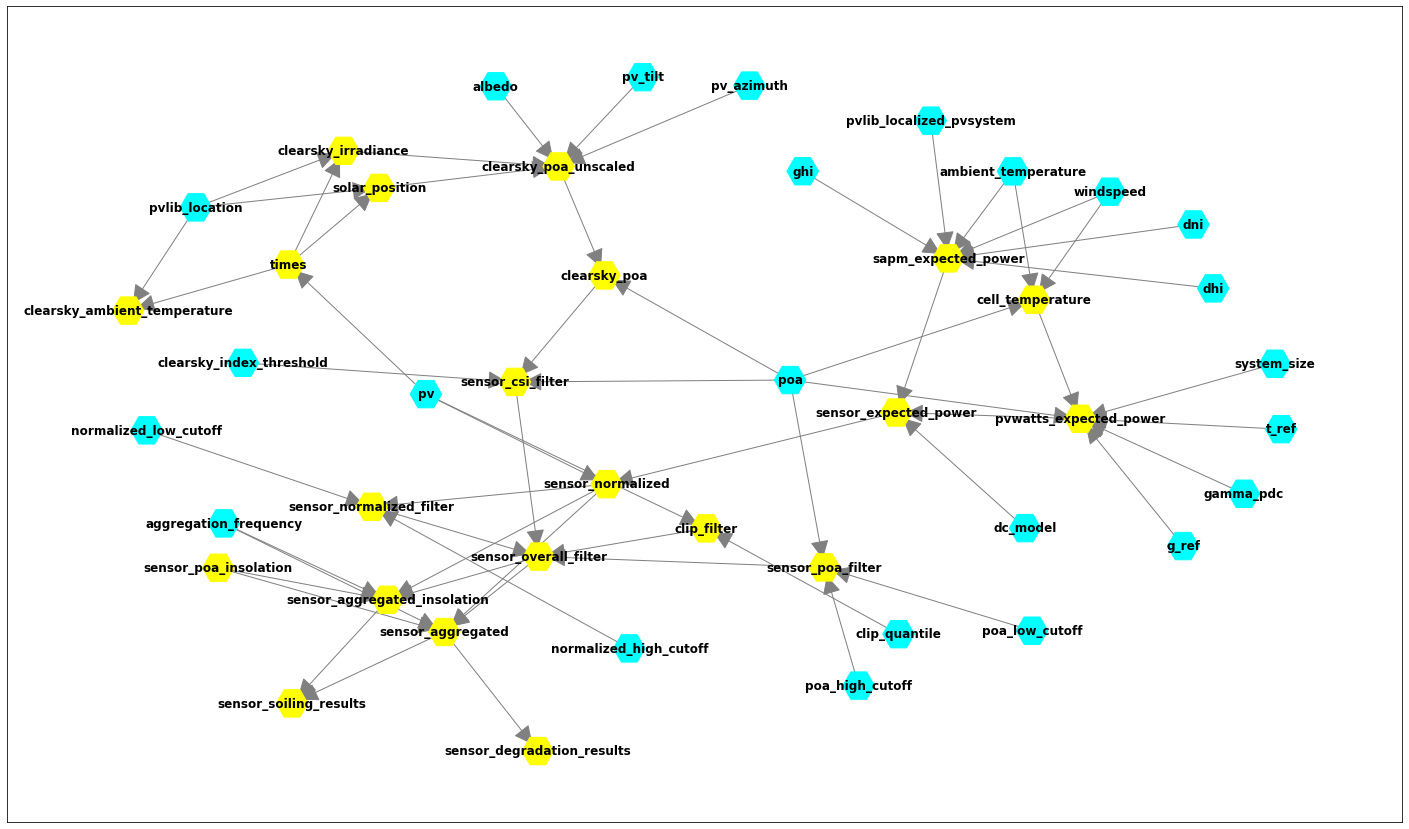

In [3]:
sa.diagram()

In [4]:
sa.calculate('sensor_aggregated')

DEBUG: checking prerequisites for sensor_aggregate: ['sensor_normalized', 'sensor_poa_insolation', 'sensor_overall_filter', 'aggregation_frequency']
DEBUG: calculating requirement sensor_normalized with provider sensor_normalize
DEBUG: checking prerequisites for sensor_normalize: ['pv', 'sensor_expected_power']
DEBUG: requirement already satisfied: pv
DEBUG: calculating requirement sensor_expected_power with provider sensor_expected_power
DEBUG: checking prerequisites for sensor_expected_power: ['dc_model']
DEBUG: requirement already satisfied: dc_model
DEBUG: calculating requirement pvwatts_expected_power with provider pvwatts
DEBUG: calculating requirement sapm_expected_power with provider sapm
DEBUG: calling sensor_expected_power with requires=['dc_model'], optional=['pvwatts_expected_power', 'sapm_expected_power'], and kwargs=[]
DEBUG: checking prerequisites for pvwatts: ['poa', 'cell_temperature', 'gamma_pdc', 'system_size', 'g_ref', 't_ref']
DEBUG: requirement already satisfied: 

ValueError: Could not run plugin "sensor_aggregate": "sensor_poa_insolation" not specified and no provider registered

DEBUG: registering plugin calc_pr: ['pv', 'expected_power']->['PR']
DEBUG: checking prerequisites for calc_pr: ['pv', 'expected_power']
DEBUG: requirement already satisfied: pv
DEBUG: requirement already satisfied: expected_power
DEBUG: calling calc_pr with requires=['pv', 'expected_power'], optional=[], and kwargs=[]


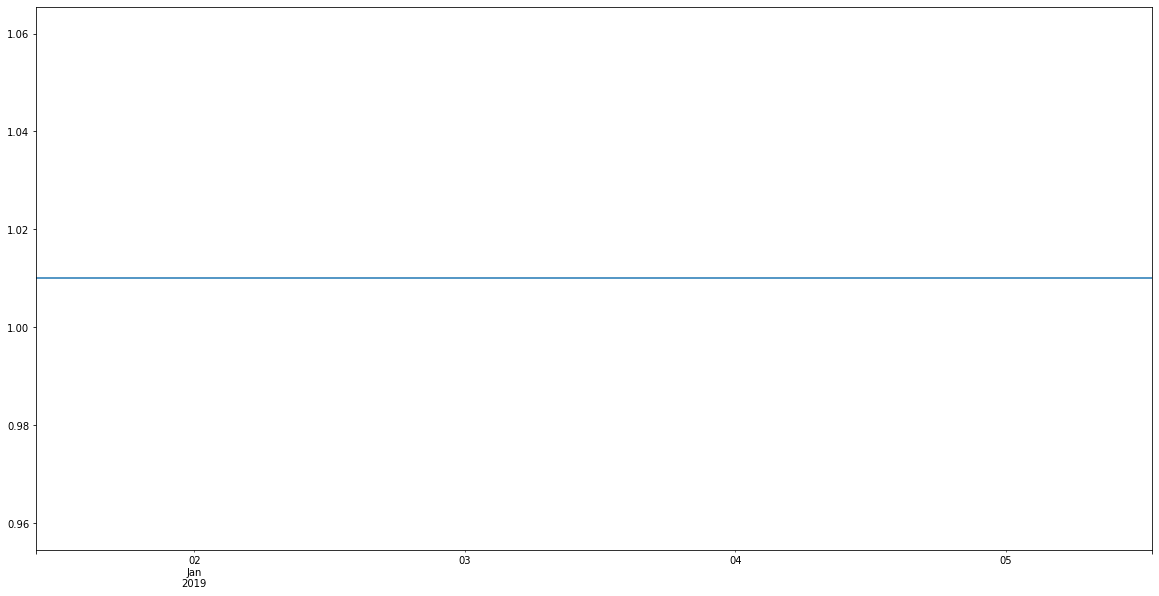

In [6]:
@sa.plugin(requires=['pv', 'expected_power'], provides=['PR'])
def calc_pr(pv, expected_power):
    return pv / expected_power

sa.calculate('PR').plot()

In [3]:
sa.trace('sensor_soiling_results', collapse_tree=True)

{'aggregation_frequency',
 'albedo',
 'clearsky_index_threshold',
 'clearsky_irradiance',
 'clearsky_poa',
 'clearsky_poa_unscaled',
 'clip_filter',
 'clip_quantile',
 'normalized_high_cutoff',
 'normalized_low_cutoff',
 'poa',
 'poa_high_cutoff',
 'poa_low_cutoff',
 'pv',
 'pv_azimuth',
 'pv_tilt',
 'pvlib_location',
 'sensor_aggregated',
 'sensor_aggregated_insolation',
 'sensor_csi_filter',
 'sensor_expected_power',
 'sensor_normalized',
 'sensor_normalized_filter',
 'sensor_overall_filter',
 'sensor_poa_filter',
 'sensor_poa_insolation',
 'solar_position',
 'times'}